Open this notebook inside docker container by running the command

`docker build -t mnn .` \
then \
`docker run -p 8888:8888 -it --rm --privileged -v $(pwd):/export mnn bash -c "jupyter lab --ip=0.0.0.0 --port=8888 --no-browser --allow-root /export"`

`--privileged` - so usb devices are available inside container \
`-v $(pwd):/export` - mount current directory into /export inside container in case we will need to extract something

### ADB
First let's check adb can see our phone attached. 
* If you don't see your device but you're 100% it's connected and usb cable support data transfer, try to google `ubuntu adb udev rules` and add udev file, then reboot.
* If instead of 'device' you see "unauthorized" - unlock you phone and accept connection.

The expected output is 
```
List of devices attached
5ea1e2e9	device
```

In [31]:
!adb devices

List of devices attached
5ea1e2e9	device



In [32]:
import os
import re
import timm
from timm.models import create_model
import pandas as pd
import torch
import numpy as np
import onnx
import onnxsim

In [33]:
RESULTS_URL = 'https://raw.githubusercontent.com/huggingface/pytorch-image-models/refs/heads/main/results/results-imagenet-real.csv'
accuracy_df = pd.read_csv(RESULTS_URL)

In [34]:
accuracy_df.head()

,model,img_size,top1,top1_err,top5,top5_err,param_count,crop_pct,interpolation,top1_diff,top5_diff,rank_diff
0,eva02_large_patch14_448.mim_m38m_ft_in22k_in1k,448,91.152,8.848,98.721,1.279,305.08,1.0,bicubic,1.098,-0.335,0
1,eva_giant_patch14_336.clip_ft_in1k,336,91.078,8.922,98.604,1.396,"1,013.01",1.0,bicubic,1.616,-0.224,5
2,eva02_large_patch14_448.mim_in22k_ft_in22k_in1k,448,91.048,8.952,98.685,1.315,305.08,1.0,bicubic,1.082,-0.331,-1
3,eva_giant_patch14_560.m30m_ft_in22k_in1k,560,90.956,9.044,98.676,1.324,"1,014.45",1.0,bicubic,1.160,-0.314,-1
4,eva02_large_patch14_448.mim_in22k_ft_in1k,448,90.930,9.070,98.678,1.322,305.08,1.0,bicubic,1.298,-0.276,-1


In [35]:
timm.list_models('mobilevit_xs*')

['mobilevit_xs']

In [36]:
models = [
    'fastvit_t8',
    'mobilenetv2_100',
    'mobilenetv3_small_100',
    'mobilenetv4_conv_small',
    'efficientnet_b0',
    'convnextv2_atto',
    'mobileone_s0',
    'tinynet_e',
    'repghostnet_050',
    'edgenext_x_small',
]
info = []
for model_name in models:
    model = create_model(model_name, pretrained=False, num_classes=0)
    hub_id = model.default_cfg['hf_hub_id'].split('/')[1]
    row = accuracy_df[accuracy_df['model'] == hub_id].iloc[0]
    info.append({
        'model': model_name,
        'img_size': model.default_cfg['input_size'][-1],
        'top1': row['top1'],
        'top5': row['top5'],
        'params': row['param_count'],
    })
info_df = pd.DataFrame(info)
info_df

,model,img_size,top1,top5,params
0,fastvit_t8,256,83.240,95.828,4.03
1,mobilenetv2_100,224,80.240,94.195,3.50
2,mobilenetv3_small_100,224,74.879,91.483,2.54
3,mobilenetv4_conv_small,224,81.668,94.991,3.77
4,efficientnet_b0,224,84.036,95.967,5.29
5,convnextv2_atto,224,84.226,96.056,3.71
6,mobileone_s0,224,78.513,93.337,5.29
7,tinynet_e,106,66.836,86.259,2.04
8,repghostnet_050,224,74.255,90.830,2.31
9,edgenext_x_small,256,82.569,95.427,2.34


In [37]:
os.makedirs('onnx_models', exist_ok=True)
def export_models(models, pretrained=False):
    for model_name in models:
        onnx_path = f'onnx_models/{model_name}.onnx'
        model = create_model(model_name, pretrained=pretrained, num_classes=0)
        model = model.eval()
        input_size = int(model.default_cfg['input_size'][-1])
        example_input = torch.randn(1, 3, input_size, input_size)
        try:
            torch.onnx.export(model, example_input, onnx_path, opset_version=11)
        except Exception as e:
            print(f'Failed to export {model_name}: {e}')
            continue
        onnx_model = onnx.load(onnx_path)
        model_simp, check = onnxsim.simplify(onnx_model)
        assert check, f'Simplification failed for {model_name}'
        onnx.save(model_simp, onnx_path)

export_models(models)

In [38]:
MNN_CONVERTER = '/mnn_framework/build_converter/MNNConvert'

def convert_to_mnn():
    os.makedirs('mnn_models', exist_ok=True)
    for model_name in models:
        onnx_path = f'onnx_models/{model_name}.onnx'
        mnn_path = f'mnn_models/{model_name}.mnn'
        output = !{MNN_CONVERTER} -f ONNX --modelFile {onnx_path} --MNNModel {mnn_path}
        if 'Converted Success!' not in output:
            print(f'Failed to convert {model_name}: {output}')
            continue
convert_to_mnn()

In [39]:
MNN_LIBS_DIR = '/mnn_framework/build_arm64-v8a'
DST_DIR = '/data/local/tmp/'

def push_to_device():
    !adb push {MNN_LIBS_DIR} {DST_DIR}
    !adb push mnn_models {DST_DIR}
push_to_device()

/mnn_framework/build_arm64-v8a/: 1388 ...194.5 MB/s (387797402 bytes in 1.902s)
mnn_models/: 10 files pushed, 0 skippe... 39.0 MB/s (101175640 bytes in 2.475s)


In [40]:
backends = {
    0: 'CPU',
    # 1: 'Metal', not supported on Android
    3: 'OpenCL',
    6: 'OpenGL',
    7: 'Vulkan'
}
THREADS = 4

In [41]:
results = []

for backend in backends:
    print(f'Backend: {backends[backend]}')
    output = !adb shell LD_LIBRARY_PATH={DST_DIR}/build_arm64-v8a {DST_DIR}/build_arm64-v8a/benchmark.out {DST_DIR}/mnn_models 32 8 {backend} {THREADS}
    output = '\n'.join(output)

    pattern = re.compile(
        r'\[ - \]\s+(\S+)\s+max\s+=\s+([\d.]+)\s+ms\s+min\s+=\s+([\d.]+)\s+ms\s+avg\s+=\s+([\d.]+)\s+ms'
    )
    lines = output.strip().split('\n')

    # Iterate over each line and apply the regex
    for line in lines:
        match = pattern.search(line)
        if match:
            model_name = match.group(1)
            max_time = float(match.group(2))
            min_time = float(match.group(3))
            avg_time = float(match.group(4))
            results.append({
                'Model Name': model_name,
                'Backend': backends[backend],
                'Max Time (ms)': max_time,
                'Min Time (ms)': min_time,
                'Avg Time (ms)': avg_time
            })

results_df = pd.DataFrame(results)
results_df

Backend: CPU
Backend: OpenCL
Backend: OpenGL
Backend: Vulkan


,Model Name,Backend,Max Time (ms),Min Time (ms),Avg Time (ms)
0,convnextv2_atto.mnn,CPU,14.438,14.129,14.241
1,mobilenetv2_100.mnn,CPU,5.192,4.756,4.858
2,tinynet_e.mnn,CPU,2.057,1.949,1.990
3,fastvit_t8.mnn,CPU,42.169,40.913,41.604
4,efficientnet_b0.mnn,CPU,15.519,14.974,15.095
5,repghostnet_050.mnn,CPU,3.280,2.811,2.882
6,mobilenetv3_small_100.mnn,CPU,3.035,2.592,2.650
7,mobilenetv4_conv_small.mnn,CPU,3.419,2.951,3.013
8,edgenext_x_small.mnn,CPU,12.414,11.806,11.930
9,mobileone_s0.mnn,CPU,16.674,16.347,16.514


looks like opengl backend is failed for all models

`mobilenetv4_conv_small` and `edgenext_x_small` seem the most promising for me \
while `mobilenetv4` performed good on both CPU and GPU `edgenext` has a significant performance drop on GPU (OpenCL) let's try to profile it

# Layer-by-layer profiling
PS: while profiling non-cpu devices can be tricky due to async nature of execution, usually `timeProfile` tool can provide some intuition of that's going on there

In [42]:
!adb shell LD_LIBRARY_PATH={DST_DIR}/build_arm64-v8a {DST_DIR}/build_arm64-v8a/timeProfile.out {DST_DIR}/mnn_models/convnextv2_atto.mnn 32 3

Use extra forward type: 3

Open Model /data/local/tmp//mnn_models/convnextv2_atto.mnn
CPU Group: [ 0  1  2  3 ], 300000 - 1785600
CPU Group: [ 4  5  6 ], 710400 - 2419200
CPU Group: [ 7 ], 825600 - 2841600
The device supports: i8sdot:1, fp16:1, i8mm: 0, sve2: 0
Sort by node name !
Node Name                                                             	Op Type              	Avg(ms)   	%        	Flops Rate 	
/head/global_pool/pool/GlobalAveragePool_output_0_raster_0            	Pooling              	0.377531  	0.089768 	0.000000   	
/head/norm/Add_1_output_0                                             	LayerNorm            	0.374062  	0.088943 	0.000053   	
/head/norm/Add_1_output_0_raster_0                                    	Raster               	0.635281  	0.151055 	0.000053   	
/stages/stages.0/blocks/blocks.0/Add_output_0                         	BinaryOp             	0.322656  	0.076720 	0.020960   	
/stages/stages.0/blocks/blocks.0/Add_output_0_raster_0                	Raster      

from there we can see that a lot of time is spent on UnaryOperation that indicates that model was not converted well and probably activation function used in convnext is not supported in mnn \
so future invistigation needed

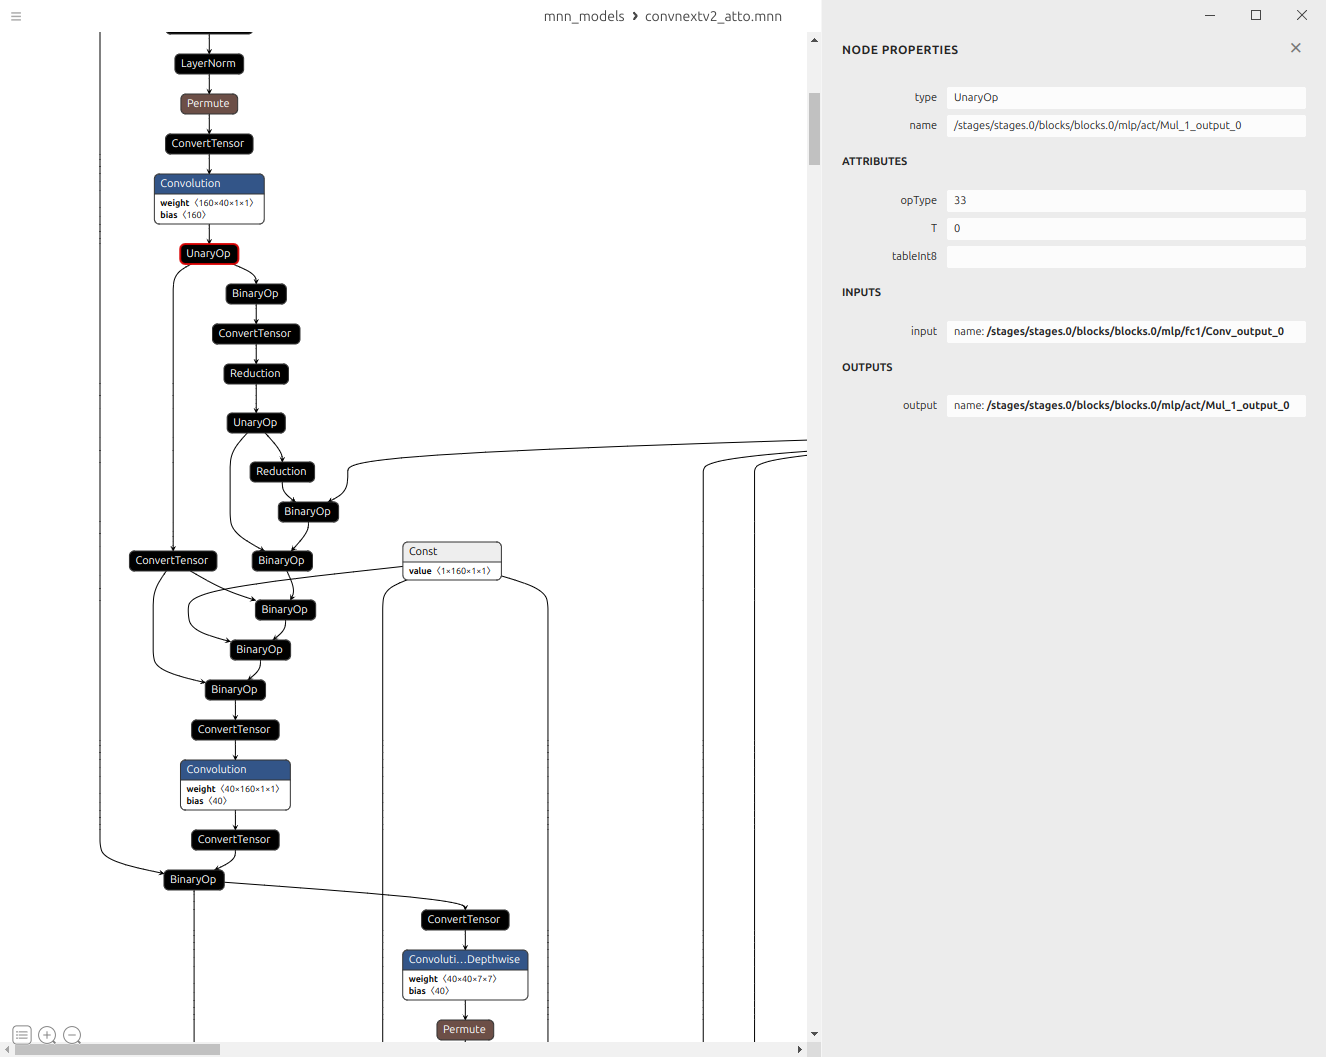

# Compare fp32 vs fp16 inference

In [43]:
!adb shell LD_LIBRARY_PATH={DST_DIR}/build_arm64-v8a {DST_DIR}/build_arm64-v8a/benchmark.out {DST_DIR}/mnn_models 32 8 1 4 0

MNN benchmark
Forward type: Metal thread=4 precision=0 sparsity=0 sparseBlockOC=1 testQuantizedModel=0
--------> Benchmarking... loop = 32, warmup = 8
[-INFO-]: precision!=2, use fp32 inference.
CPU Group: [ 0  1  2  3 ], 300000 - 1785600
CPU Group: [ 4  5  6 ], 710400 - 2419200
CPU Group: [ 7 ], 825600 - 2841600
The device supports: i8sdot:1, fp16:1, i8mm: 0, sve2: 0
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] convnextv2_atto.mnn         max =   26.217 ms  min =   25.670 ms  avg =   25.938 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] mobilenetv2_100.mnn         max =    9.057 ms  min =    8.653 ms  avg =    8.846 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] tinynet_e.mnn               max =    2.576 ms  min =    2.186 ms  avg =    2.351 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] fastvit_t8.mnn           

In [44]:
!adb shell LD_LIBRARY_PATH={DST_DIR}/build_arm64-v8a {DST_DIR}/build_arm64-v8a/benchmark.out {DST_DIR}/mnn_models 32 8 1 4 2

MNN benchmark
Forward type: Metal thread=4 precision=2 sparsity=0 sparseBlockOC=1 testQuantizedModel=0
--------> Benchmarking... loop = 32, warmup = 8
[-INFO-]: precision=2, use fp16 inference if your device supports and open MNN_ARM82=ON.
CPU Group: [ 0  1  2  3 ], 300000 - 1785600
CPU Group: [ 4  5  6 ], 710400 - 2419200
CPU Group: [ 7 ], 825600 - 2841600
The device supports: i8sdot:1, fp16:1, i8mm: 0, sve2: 0
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] convnextv2_atto.mnn         max =   14.577 ms  min =   14.020 ms  avg =   14.145 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] mobilenetv2_100.mnn         max =    5.234 ms  min =    4.760 ms  avg =    4.878 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] tinynet_e.mnn               max =    2.051 ms  min =    1.952 ms  avg =    1.983 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, 

from the resulst above indeed we can see that fp16 is almost 2x faster than fp32 \
this results are interesting because on x86 (eg using openvino) the results are opposite

# Compare random weights and pre-trained model

In [45]:
export_models(models, pretrained=True)
convert_to_mnn()
push_to_device()
!adb shell LD_LIBRARY_PATH={DST_DIR}/build_arm64-v8a {DST_DIR}/build_arm64-v8a/benchmark.out {DST_DIR}/mnn_models 32 8 1 4 2

/mnn_framework/build_arm64-v8a/: 1388 ...193.4 MB/s (387797402 bytes in 1.913s)
mnn_models/: 10 files pushed, 0 skippe... 38.7 MB/s (101291256 bytes in 2.495s)
MNN benchmark
Forward type: Metal thread=4 precision=2 sparsity=0 sparseBlockOC=1 testQuantizedModel=0
--------> Benchmarking... loop = 32, warmup = 8
[-INFO-]: precision=2, use fp16 inference if your device supports and open MNN_ARM82=ON.
CPU Group: [ 0  1  2  3 ], 300000 - 1785600
CPU Group: [ 4  5  6 ], 710400 - 2419200
CPU Group: [ 7 ], 825600 - 2841600
The device supports: i8sdot:1, fp16:1, i8mm: 0, sve2: 0
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] convnextv2_atto.mnn         max =   14.604 ms  min =   14.194 ms  avg =   14.313 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instead
[ - ] mobilenetv2_100.mnn         max =    5.084 ms  min =    4.770 ms  avg =    4.858 ms
Can't Find type=1 backend, use 0 instead
Can't Find type=1 backend, use 0 instea

from the above we can see that weights initialization doesn't affect execution time